# Importing Libraries

In [1]:
# PyTorch
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np

import os

## Setting up global variables

In [2]:
# Setting Pytorch to GPU if Possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
data_path = os.path.dirname(os.getcwd()) + '/dataset'
trainset_path = data_path + '/train'
testset_path = data_path + '/test'

In [4]:
trainset_path

'D:\\git\\Cell-Images-Parasitized-or-Uninfected-Pytorch/dataset/train'

In [5]:
data_path

'D:\\git\\Cell-Images-Parasitized-or-Uninfected-Pytorch/dataset'

# Import Dataset and apply Augmentations

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((64, 64)),
     transforms.Pad(6),
     transforms.RandomRotation(degrees=(0, 360))
    ])

batch_size = 64

trainset = torchvision.datasets.ImageFolder(
    root=trainset_path,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.ImageFolder(
    root=testset_path,
    transform=transform
)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

trainset.class_to_idx

{'parasitized': 0, 'uninfected': 1}

In [7]:
testset

Dataset ImageFolder
    Number of datapoints: 2600
    Root location: D:\git\Cell-Images-Parasitized-or-Uninfected-Pytorch/dataset/test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               Pad(padding=6, fill=0, padding_mode=constant)
               RandomRotation(degrees=[0.0, 360.0], interpolation=nearest, expand=False, fill=0)
           )

In [8]:
# Saving Dict to a list for later use
classes = list(trainset.class_to_idx)

In [9]:
classes

['parasitized', 'uninfected']

## Visualize data after agmentation

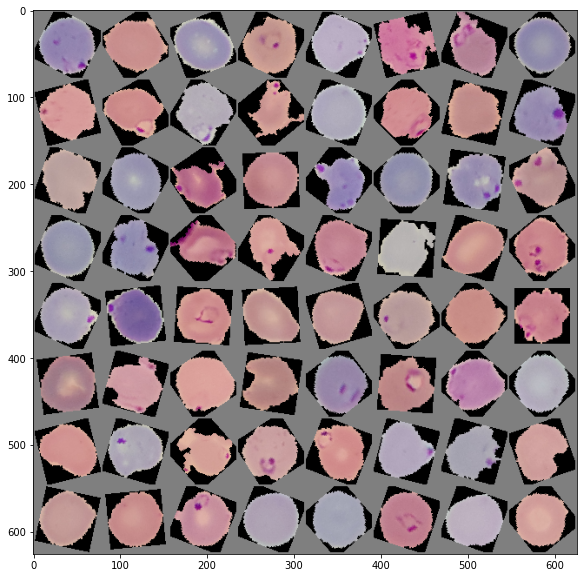

In [10]:
# functions to show an image
def imshow(img):
    plt.figure(figsize=(10, 10))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images, 8))

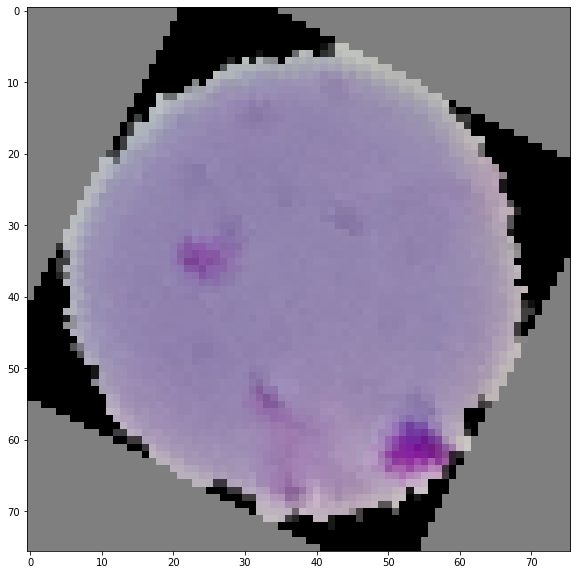

In [11]:
imshow(images[0])

In [12]:
images[0].shape

torch.Size([3, 76, 76])

# Creating the model

In [13]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,2)
        self.conv2 = nn.Conv2d(6,10,3)
#         self.fc1 = nn.Linear(184960, 10000)
        self.fc1 = nn.Linear(10 * 17 * 17, 10000)
        self.fc2 = nn.Linear(10000, 5000)
        self.fc3 = nn.Linear(5000, 2500)
        self.fc4 = nn.Linear(2500, 1500)
        self.fc5 = nn.Linear(1500, 750)
        self.fc6 = nn.Linear(750, len(classes))
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
#         x = torch.flatten(x)
#         print(x.shape)
#         x = x.view(-1, 184960)
        x = x.view(x.size(0), -1)
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
#         x = F.relu(self.fc6(x))
        x = self.fc6(x)
        return x
    
model = Model().to(device)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
total_loss = []

for epoch in range(8):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
       
        if i % 100 == 99:
            print('[epoch, batch] =  [%d, %5d] loss: %.6f' %(epoch + 1, i, running_loss / 100))
            total_loss.append(running_loss / 100)
            running_loss = 0.0

print('Finished Training')

[epoch, batch] =  [1,    99] loss: 0.673794
[epoch, batch] =  [1,   199] loss: 0.602679
[epoch, batch] =  [1,   299] loss: 0.514302
[epoch, batch] =  [2,    99] loss: 0.187842
[epoch, batch] =  [2,   199] loss: 0.182925
[epoch, batch] =  [2,   299] loss: 0.168945
[epoch, batch] =  [3,    99] loss: 0.171023
[epoch, batch] =  [3,   199] loss: 0.144979
[epoch, batch] =  [3,   299] loss: 0.156181
[epoch, batch] =  [4,    99] loss: 0.151116
[epoch, batch] =  [4,   199] loss: 0.132895
[epoch, batch] =  [4,   299] loss: 0.144036
[epoch, batch] =  [5,    99] loss: 0.142415
[epoch, batch] =  [5,   199] loss: 0.126769
[epoch, batch] =  [5,   299] loss: 0.133536
[epoch, batch] =  [6,    99] loss: 0.128752
[epoch, batch] =  [6,   199] loss: 0.135436
[epoch, batch] =  [6,   299] loss: 0.126332
[epoch, batch] =  [7,    99] loss: 0.131666
[epoch, batch] =  [7,   199] loss: 0.122050
[epoch, batch] =  [7,   299] loss: 0.147731
[epoch, batch] =  [8,    99] loss: 0.124243
[epoch, batch] =  [8,   199] los

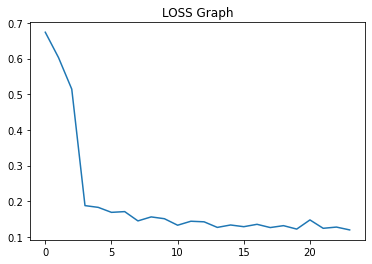

In [16]:
plt.plot(total_loss)
plt.title("LOSS Graph")
plt.show()

In [23]:
correct = 0
total = 0

incorrect_predictions = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images.to(device))
        # the class with the highest energy is what we choose as prediction
        extra_out, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
        print(outputs)

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

tensor([[ 5.2800, -6.3885],
        [ 3.5508, -4.2871],
        [ 3.1218, -3.7808],
        [ 2.9942, -3.5938],
        [ 0.7550, -0.8825],
        [ 4.8948, -5.8936],
        [ 3.8763, -4.6377],
        [ 3.9690, -4.7654],
        [ 5.7834, -6.9941],
        [ 3.9210, -4.7131],
        [ 3.6374, -4.3798],
        [ 3.8175, -4.6288],
        [ 1.5301, -1.8268],
        [ 4.3160, -5.1982],
        [ 3.8242, -4.6118],
        [ 4.4090, -5.2818],
        [ 2.8148, -3.3794],
        [ 4.5736, -5.5073],
        [ 5.9145, -7.1211],
        [ 3.5697, -4.2847],
        [ 2.6273, -3.1718],
        [ 6.3190, -7.6170],
        [ 3.6119, -4.3664],
        [ 3.2403, -3.8921],
        [ 4.0626, -4.8712],
        [ 4.5685, -5.4734],
        [ 3.7244, -4.4817],
        [ 4.4691, -5.3943],
        [ 1.3528, -1.6039],
        [ 3.4702, -4.1815],
        [ 3.1652, -3.8015],
        [ 5.2708, -6.3310],
        [ 3.4177, -4.1086],
        [ 0.4232, -0.4823],
        [ 4.1307, -4.9868],
        [ 3.3201, -3

tensor([[  1.4256,  -1.7074],
        [  1.3947,  -1.6649],
        [  0.7593,  -0.8823],
        [  1.6078,  -1.9116],
        [  4.1275,  -4.9947],
        [  2.5761,  -3.1063],
        [  5.1495,  -6.1702],
        [  3.9153,  -4.6960],
        [  2.9774,  -3.5999],
        [  1.1380,  -1.3488],
        [  2.2818,  -2.7432],
        [  3.1843,  -3.8564],
        [  1.8432,  -2.1997],
        [  6.3021,  -7.5599],
        [  2.2643,  -2.7289],
        [  0.7942,  -0.9334],
        [  2.0857,  -2.5087],
        [  3.2158,  -3.8817],
        [  3.4816,  -4.1904],
        [ 10.1486, -12.2268],
        [  4.4000,  -5.3088],
        [  3.3978,  -4.1117],
        [  3.5273,  -4.2352],
        [  2.3136,  -2.7493],
        [  2.3423,  -2.8313],
        [  2.4258,  -2.9256],
        [  2.0706,  -2.4906],
        [  3.0410,  -3.6654],
        [  3.2397,  -3.9141],
        [  4.0219,  -4.8206],
        [  3.8216,  -4.6383],
        [  3.9351,  -4.7557],
        [  5.5777,  -6.7807],
        [ 

tensor([[  1.7403,  -2.0749],
        [ -0.1589,   0.2702],
        [  5.2717,  -6.3549],
        [  3.4392,  -4.1734],
        [  1.0350,  -1.2245],
        [  2.7889,  -3.3527],
        [  4.3264,  -5.2170],
        [  5.0020,  -6.0437],
        [  4.9273,  -5.9505],
        [  4.3877,  -5.2623],
        [  5.3461,  -6.4347],
        [  6.4012,  -7.7604],
        [  6.1224,  -7.3970],
        [  4.4888,  -5.4278],
        [  4.3109,  -5.1766],
        [  6.0161,  -7.2611],
        [  5.1495,  -6.2187],
        [  4.1990,  -5.0497],
        [  2.3144,  -2.7681],
        [  5.0503,  -6.0475],
        [  5.7998,  -7.0106],
        [  0.3831,  -0.4375],
        [  3.3591,  -4.0413],
        [  3.4940,  -4.2003],
        [  1.8875,  -2.2785],
        [  2.9826,  -3.5983],
        [  4.2993,  -5.1755],
        [  5.0304,  -6.0604],
        [  3.2947,  -3.9536],
        [  1.0346,  -1.2372],
        [  5.1716,  -6.2170],
        [  0.5454,  -0.6319],
        [  3.1637,  -3.8295],
        [ 

tensor([[-1.1560,  1.7210],
        [-1.4192,  2.1022],
        [-1.6146,  2.3850],
        [-1.2067,  1.7949],
        [-2.0058,  2.9520],
        [-0.3144,  0.5019],
        [-1.3748,  2.0379],
        [-1.1540,  1.7186],
        [-0.5943,  0.9071],
        [-0.4967,  0.7667],
        [-1.7406,  2.5675],
        [-1.5799,  2.3353],
        [-1.7529,  2.5858],
        [-1.0820,  1.6140],
        [-1.8676,  2.7518],
        [-1.3846,  2.0522],
        [-1.8814,  2.7723],
        [-1.5813,  2.3370],
        [-0.7869,  1.1859],
        [-1.8499,  2.7263],
        [-1.5083,  2.2314],
        [-2.0273,  2.9830],
        [-2.3080,  3.3893],
        [ 0.4549, -0.5132],
        [-0.9465,  1.4174],
        [-1.9064,  2.8075],
        [-1.9309,  2.8434],
        [-1.3768,  2.0410],
        [-0.2982,  0.4764],
        [-1.6228,  2.3971],
        [-2.4181,  3.5489],
        [ 0.6119, -0.7164],
        [-2.3385,  3.4282],
        [-1.3102,  1.9391],
        [-1.7470,  2.5719],
        [-0.9462,  1

tensor([[-1.8708,  2.7563],
        [-1.9009,  2.8000],
        [-2.5383,  3.7230],
        [ 0.7125, -0.8236],
        [-2.0793,  3.0590],
        [-1.7914,  2.6414],
        [-2.2174,  3.2583],
        [-2.9262,  4.2841],
        [-2.5059,  3.6760],
        [-1.8133,  2.6733],
        [-1.8745,  2.7617],
        [-2.8168,  4.1257],
        [-1.4817,  2.1929],
        [ 0.8171, -0.9542],
        [-2.4024,  3.5258],
        [-1.2607,  1.8729],
        [-1.8293,  2.6971],
        [-1.0835,  1.6162],
        [ 0.4403, -0.4952],
        [-1.5010,  2.2210],
        [-1.8871,  2.7795],
        [-2.2523,  3.3090],
        [-1.3681,  2.0281],
        [-1.9316,  2.8445],
        [-2.1131,  3.1073],
        [-1.6759,  2.4741],
        [-2.2746,  3.3414],
        [-2.6149,  3.8338],
        [-2.4491,  3.5929],
        [-2.9102,  4.2612],
        [-2.3208,  3.4077],
        [-3.2439,  4.7446],
        [-1.5241,  2.2535],
        [-2.4974,  3.6640],
        [-1.6960,  2.5028],
        [-2.0141,  2

Accuracy of the network on the test images: 95 %


In [18]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels.to(device), predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class parasitized is: 95.7 %
Accuracy for class uninfected is: 95.4 %
